In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging

logger = logging.getLogger()
fhandler = logging.FileHandler(filename="mylog.log", mode="a")
formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from MDAnalysis.analysis import align
import warnings

from cryo_md.image.image_stack import ImageStack
from cryo_md.wpa_simulator.simulator import simulate_stack
from cryo_md.utils.parser import pdb_parser
from cryo_md.pipeline.pipeline import Pipeline
from cryo_md.main import run_cryomd
from cryo_md.molecular_dynamics.md_sampling import MDSampler
from cryo_md.optimization.optimizer import WeightOptimizer, PositionOptimizer

warnings.filterwarnings("ignore", module="MDAnalysis")

# 1. Generating images from two references 

There are four pdb files involved in this tutorial, ala_ref_{0,1}.pdb are the pdb files we will use to generate images, and init_system_{0, 1}.pdb are the starting structures for the optimization.

First we will define a reference universe when doing the optimization, so it's important to not change it. For this tutorial I will use ala_ref_0.pdb. In addition, we will use all the heavy atoms (every non hydrogen atom).

In [4]:
n_models = 2
unit_cell = [34.0, 34.0, 34.0, 90.0, 90.0, 90.0]

ref_universe = mda.Universe("ala_ref_0.pdb")

mda_filter = "protein and not name H*"

Now we will save the atomic coordinates to a numpy array so we can generate images. We will also load the structural information of the system, which includes the atomic numbers and residue radii in case you will optimize in coarse-grained mode (not in this tutorial)

In [5]:
models = np.zeros((n_models, *ref_universe.select_atoms(mda_filter).positions.T.shape))

for i in range(models.shape[0]):
    uni = mda.Universe(f"ala_ref_{i}.pdb")
    align.alignto(uni, ref_universe, select=mda_filter, match_atoms=True)
    models[i] = uni.select_atoms(mda_filter).positions.T

struct_info = pdb_parser("ala_ref_0.pdb", mode="all-atom")

models.shape

(2, 3, 20)

Now we will define the parameters for the imaging, the defocus and the snr can be defined either as single values or as a range of values. In this case we use a range for the snr and a single value for the defocus.

In [6]:
config = {
    "box_size": 48,
    "pixel_size": 0.3,
    "res": 0.4,
    "ctf_amp": 0.9,
    "ctf_bfactor": 1.0,
    "ctf_defocus": 0.01,
    "noise_snr": [0.5, 2.0],
    "noise_radius_mask": 24,
}

You can define how many images you want for each model by tuning the "images_per_model" argument. You need to provide a list of the same size as n_models, or simply a single number if you want all models to have the same amount of images.

In [7]:
image_stack = simulate_stack(
    models,
    struct_info,
    images_per_model=[1000, 1000],
    config=config,
    batch_size=100,
    seed=0,
)

Now let's visualize a random set of the generated images

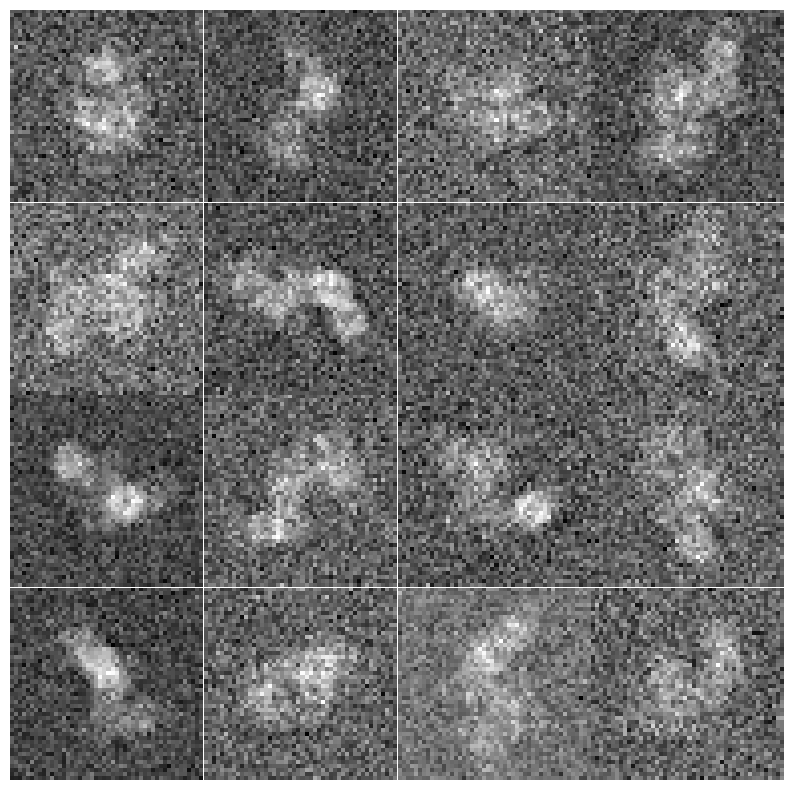

In [8]:
fig, axes = plt.subplots(
    4, 4, figsize=(10, 10), gridspec_kw={"wspace": 0, "hspace": 0}, squeeze=True
)

indices = np.random.choice(1000, 16, replace=False)

for i, ax in enumerate(axes.flatten()):
    ax.imshow(image_stack.images[indices[i]].T, origin="lower", cmap="gray")
    ax.axis("off")

You can save the images using the `save()` method included in the ImageStack class

In [9]:
image_stack.save("ala_images.npz")

In addition, you can load the saved image stack by simply giving the file name to the stack when calling the constructor 

In [10]:
image_stack = ImageStack("ala_images.npz")

# 2. Running the optimization method

## 2.1 Setting up the workflow for the optimization

First we will define a few variables, and set up the methods we will use for the optimization.

*Note: when I refer to "number of steps" here, I refer to the number of steps perfomed at each iteration of the optimization*

The methods included in this repo are: 

### MDSampler
This method runs a biased molecular dynamics using a hamiltonian of the form

$$H_{MD}(x) + \frac{1}{2} k \text{RMSD}(S(x), s)^2$$

where $S(\cdot)$ is a function that extracs a subset of atoms, all the heavy atoms in this case, $s$ is a reference structure, and RMSD(x, y) is simply the root mean square distance between structures x and y. Lastly, $k$ is the strenght of the biasing force.

For the MD sampler you can tune the number of MD steps, the value of the strength constant $k$, and many other parameters that are part of the OpenMM pipeline. For this tutorial we will run the simulations using 16 CPU cores.

### Optimizers

We have two optimizers, which maximize the likelihood

$$p(\{y\} | \{x\}, \{\alpha\}) = \sum_{i} \log \sum_{m} \alpha_m p(y_i | x_m)$$ 

#### Weight Optimizer

This optimizer simply uses gradient descent to estimate the relative weights $\{\alpha\}$, you can set up the number of steps and the step size.

### Position Optimizer

We only perform one position (structure) optimization step at a time, so unlike with the weights the number of steps is not a parameter. The position optimizer only has two parameters, which are really important.

* Step size: this is a step size in angstrom, it is how much you move the atoms when you perform the optimization.
* Batch size: we do stochastic gradient descent, this is simply how many images you take of the full stack. If the batch size it's too low, you might get drifted away by the noise in the images. If it's too large, you might get stuck on local minima.



Now let's define each of these methods in the code

In [11]:
md_sampler = MDSampler(
    restrain_force_constant=300000.0,
    n_steps=400,
    platform="CPU",
    properties={"Threads": "16"},
)


wts_opt = WeightOptimizer(n_steps=10, step_size=0.1)
pos_opt = PositionOptimizer(step_size=0.5, batch_size=200)

We can now combine these steps to make a pipeline. For the moment only one type of pipeline is allowed, which is

WeightOptimizer -> PositionOptimizer -> as many MDSamplers as you want

In [12]:
workflow = [wts_opt, pos_opt, md_sampler]

pipeline = Pipeline(workflow)

## 2.2 Running CryoMD

Lastly, we run the optimization method. Remember we generated the images using all the atoms, so we run the optimization in `"all-atom"` mode. We will try to find 2 models, and will use the reference universe we defined at the beginning of the notebook for alignment. The losses, weights, and trajectory will be saved in a file called `"outputs.h5`.

In [13]:
optimization_steps = 2

run_cryomd(
    pipeline,
    mode="all-atom",
    image_stack=image_stack,
    n_models=n_models,
    n_steps=optimization_steps,
    ref_universe=ref_universe,
    output_file="outputs.h5",
)

100%|██████████| 2/2 [00:18<00:00,  9.39s/step, loss=-291632.44]


3. Analysing the results

(This uses something I will define as a method of the library in the near future)

The following cell will load the results, write a trajectory, and save the losses and the evolution of the weights to numyp arrays

In [15]:
import h5py

with h5py.File("outputs.h5", "r") as file:
    losses = file["losses"][:]
    traj_wts = file["trajs_weights"][:]
    n_frames, n_models, _, n_atoms = file["trajs_positions"].shape
    univ = mda.Universe("ala_ref_0.pdb")

    for i in range(n_models):
        with mda.Writer(f"traj_{i}.pdb", n_atoms) as W:
            for j in range(n_frames):
                univ.atoms.positions = file["trajs_positions"][j, i, :, :].T
                align.alignto(
                    univ, ref_universe, select="not name H*", match_atoms=True
                )
                W.write(univ)

In [ ]:
plt.plot(losses)

In [ ]:
plt.plot(traj_wts)